In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import importlib
warnings.filterwarnings('ignore')

In [4]:
from analysis.data.dataframe_creation import pipeline
sd = "2018-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)


[*********************100%***********************]  1 of 1 completed


Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['GEV', 'SOLV', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1704085200")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-01-01)')



Null values: False
NaN values: False

Creating features
The dataset has 485 assets
The dataset has 16 predictors:
Ticker
Yavg_return
Yavg_volatility
beta
mkt_corr
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry


Dataset creation finished



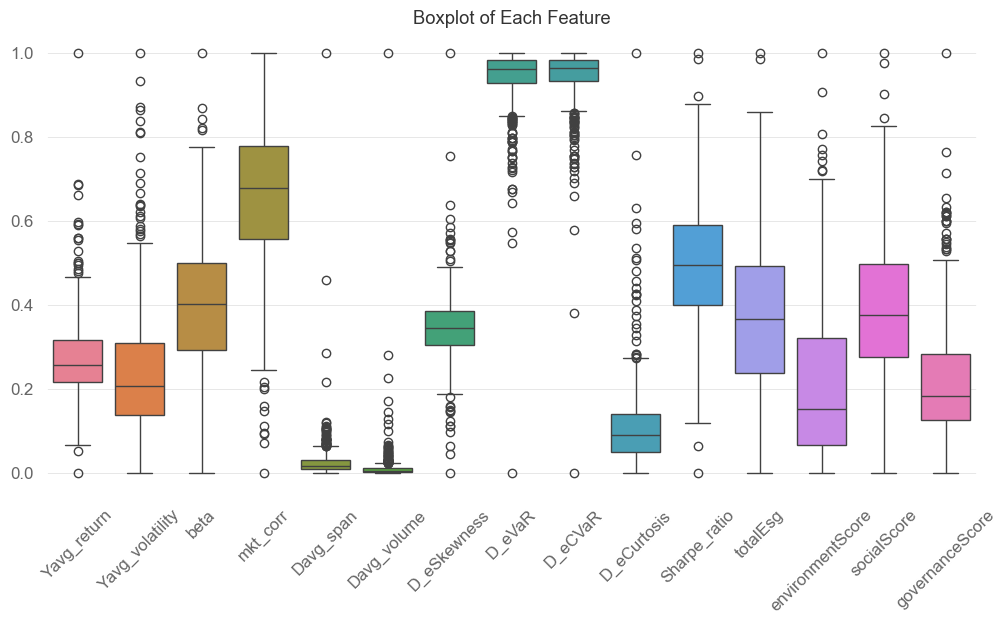

In [5]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
plt.figure(figsize=(12, 6))
scaled_data = pd.DataFrame()
for attr in dataset.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    scaled_data[attr] = scaler.fit_transform(dataset[attr].values.reshape(-1, 1)).flatten()
sns.boxplot(data=scaled_data)

# Customize labels
plt.xticks(rotation=45)  # Rotate feature names if needed
plt.title("Boxplot of Each Feature")
plt.show()

Removed 8 observations


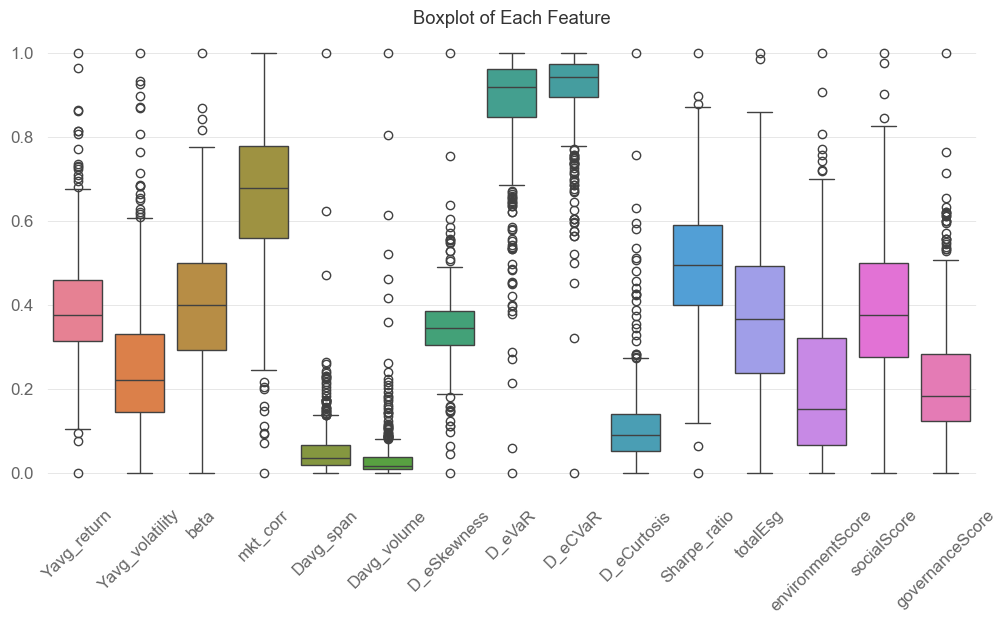

In [6]:
from scipy.spatial.distance import cdist
threshold = 0.3  # Distance threshold

data = scaled_data.values
n_samples, n_features = data.shape


rows_to_keep = np.ones(n_samples, dtype=bool)


for i in range(n_samples):
    for j in range(n_features):
        # Compute distances for the current feature (ignoring self-comparison)
        distances = np.abs(data[:, j] - data[i, j])
        distances[i] = np.inf  # Ignore self-distance

        # If no value is within threshold, mark row for deletion
        if not np.any(distances < threshold):
            rows_to_keep[i] = False
            break  # No need to check other features, remove row immediately

# Filter DataFrame
filtered_df = dataset[rows_to_keep]
print(f"Removed {len(dataset)-len(filtered_df)} observations")
plt.figure(figsize=(12, 6))
scaled_data = pd.DataFrame()
for attr in filtered_df.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    scaled_data[attr] = scaler.fit_transform(filtered_df[attr].values.reshape(-1, 1)).flatten()
sns.boxplot(data=scaled_data)

# Customize labels
plt.xticks(rotation=45)  # Rotate feature names if needed
plt.title("Boxplot of Each Feature")
plt.show()

In [7]:
final_dataframe = dataset[rows_to_keep]
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry
0,A,0.170255,0.290318,1.006775,0.707046,2.268208,1.961764e+06,-0.134995,-0.000283,-0.000401,4.334483,0.517552,11.36,1.19,6.23,3.93,Life Sciences Tools and Services
1,AAPL,0.309906,0.316770,1.238242,0.796984,2.378506,1.073273e+08,-0.036495,-0.000292,-0.000426,4.924368,0.915194,16.79,0.55,7.52,8.72,Technology
2,ABBV,0.159055,0.273195,0.657252,0.490510,2.003774,7.196053e+06,-0.845040,-0.000286,-0.000483,13.941146,0.508994,26.10,1.78,15.70,8.62,Biotechnology
3,ABT,0.155088,0.257788,0.853279,0.674864,1.733056,5.701730e+06,0.048210,-0.000290,-0.000434,6.096809,0.524026,22.21,1.81,13.84,6.56,Health Care
4,ACGL,0.204344,0.314158,0.979198,0.635494,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance


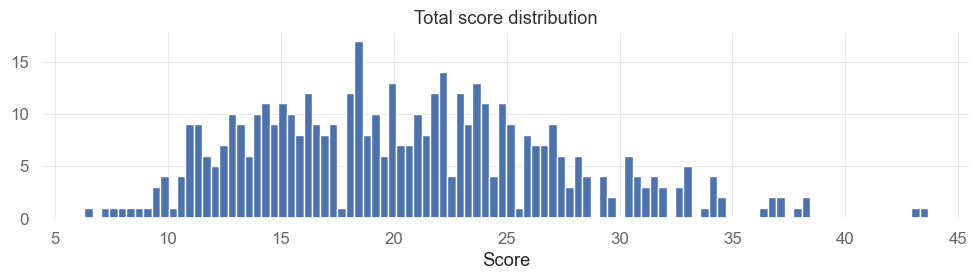

In [8]:
plt.figure(figsize=(10,3))
# stock_data["totalEsg"].value_counts().plot(kind="hist", bins=10)
plt.hist(final_dataframe["totalEsg"], bins=100)
plt.title("Total score distribution")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

In [9]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, 0 to 484
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ticker            477 non-null    object 
 1   Yavg_return       477 non-null    float64
 2   Yavg_volatility   477 non-null    float64
 3   beta              477 non-null    float64
 4   mkt_corr          477 non-null    float64
 5   Davg_span         477 non-null    float64
 6   Davg_volume       477 non-null    float64
 7   D_eSkewness       477 non-null    float64
 8   D_eVaR            477 non-null    float64
 9   D_eCVaR           477 non-null    float64
 10  D_eCurtosis       477 non-null    float64
 11  Sharpe_ratio      477 non-null    float64
 12  totalEsg          477 non-null    float64
 13  environmentScore  477 non-null    float64
 14  socialScore       477 non-null    float64
 15  governanceScore   477 non-null    float64
 16  industry          390 non-null    object 
dtypes:

In [10]:
stock_data_clustering = final_dataframe.copy()
for attr in filtered_df.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    stock_data_clustering[attr] = scaler.fit_transform(final_dataframe[attr].values.reshape(-1, 1)).flatten()

for type, feature in zip(final_dataframe.dtypes, final_dataframe.columns):
    if type == "object" and feature!="Ticker":
        stock_data_clustering[feature] = final_dataframe[feature].astype('category').cat.codes
        scaler = MinMaxScaler()
        stock_data_clustering[feature] = scaler.fit_transform(stock_data_clustering[feature].values.reshape(-1, 1)).flatten()
stock_data_clustering = stock_data_clustering.dropna()
stock_data_clustering = stock_data_clustering.drop(columns=["Ticker", "Sharpe_ratio"])
stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, 0 to 484
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Yavg_return       477 non-null    float64
 1   Yavg_volatility   477 non-null    float64
 2   beta              477 non-null    float64
 3   mkt_corr          477 non-null    float64
 4   Davg_span         477 non-null    float64
 5   Davg_volume       477 non-null    float64
 6   D_eSkewness       477 non-null    float64
 7   D_eVaR            477 non-null    float64
 8   D_eCVaR           477 non-null    float64
 9   D_eCurtosis       477 non-null    float64
 10  totalEsg          477 non-null    float64
 11  environmentScore  477 non-null    float64
 12  socialScore       477 non-null    float64
 13  governanceScore   477 non-null    float64
 14  industry          477 non-null    float64
dtypes: float64(15)
memory usage: 59.6 KB


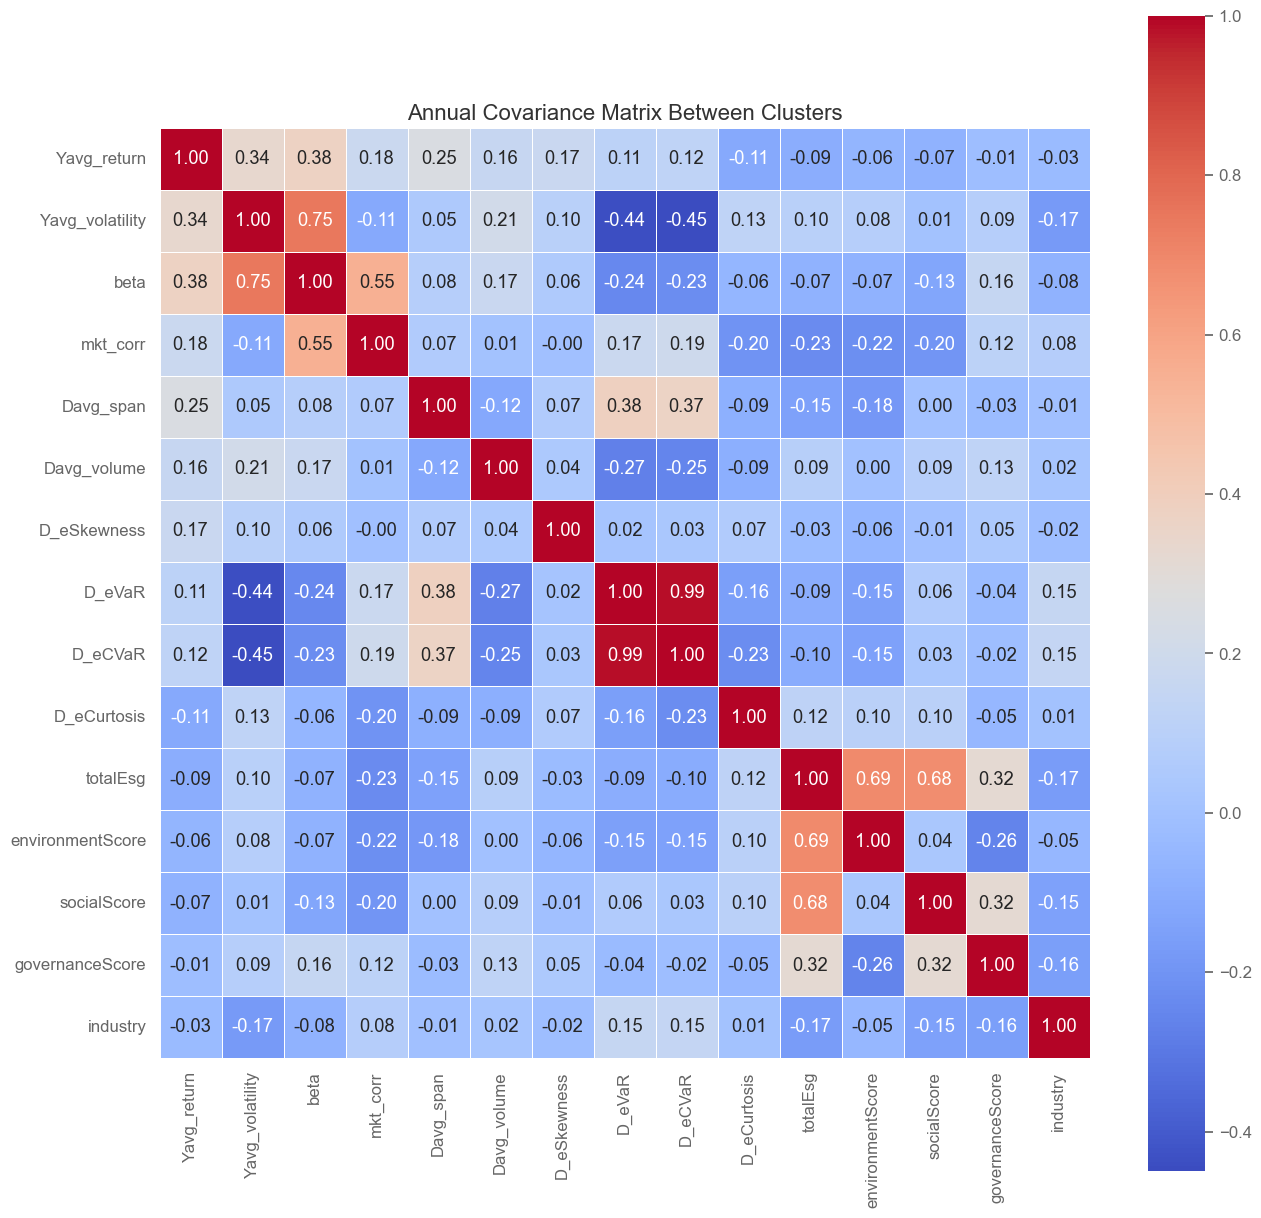

In [11]:
import seaborn as sns
correlation = stock_data_clustering.corr()
plt.figure(figsize=(15, 15))  
sns.heatmap(
    correlation, 
    annot=True,  # Annotate the heatmap with the covariance values
    fmt=".2f",   # Format for the numbers
    cmap="coolwarm",  # Colormap for the heatmap
    linewidths=0.5,   # Add grid lines
    square=True       # Make the heatmap square
)

# 3. Add a title
plt.title("Annual Covariance Matrix Between Clusters", fontsize=16)
plt.show()

In [12]:
useless = ["D_eVaR", "Davg_span", "D_eSkewness", "Davg_volume"]
stock_data_clustering = stock_data_clustering.drop(columns=useless)

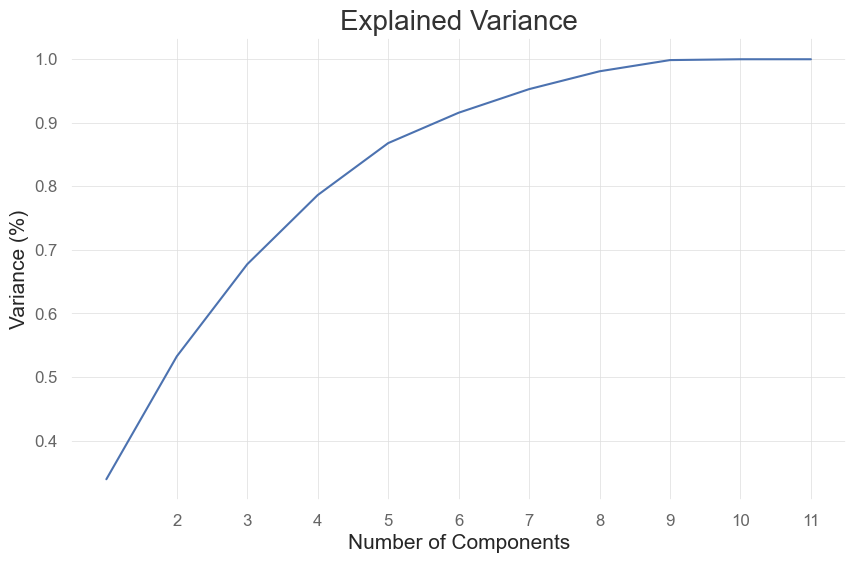

In [13]:
from sklearn.decomposition import PCA

# pass through the scaled data set into our PCA class object
pca = PCA().fit(stock_data_clustering)

# plot the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.arange(1,len(stock_data_clustering.columns)+1), np.cumsum(pca.explained_variance_ratio_))

# define the labels & title
plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Variance (%)', fontsize = 15) 
plt.title('Explained Variance', fontsize = 20)
plt.xticks(np.arange(1,len(stock_data_clustering.columns))+1)
# show the plot
plt.show()

In [14]:
n= 6
pca_dataset = PCA(n_components=n).fit(stock_data_clustering).transform(stock_data_clustering)

# store it in a new data frame
pca_dataset= pd.DataFrame(data = pca_dataset, columns = [f'principal component {i+1}' for i in range(n)])

In [15]:
from analysis.clustering.kmeans_clustering import run_kmeans
clusters = range(2, 20)
runs = 60
meanDistortions, sil_score, inertias = run_kmeans(clusters, pca_dataset, runs)

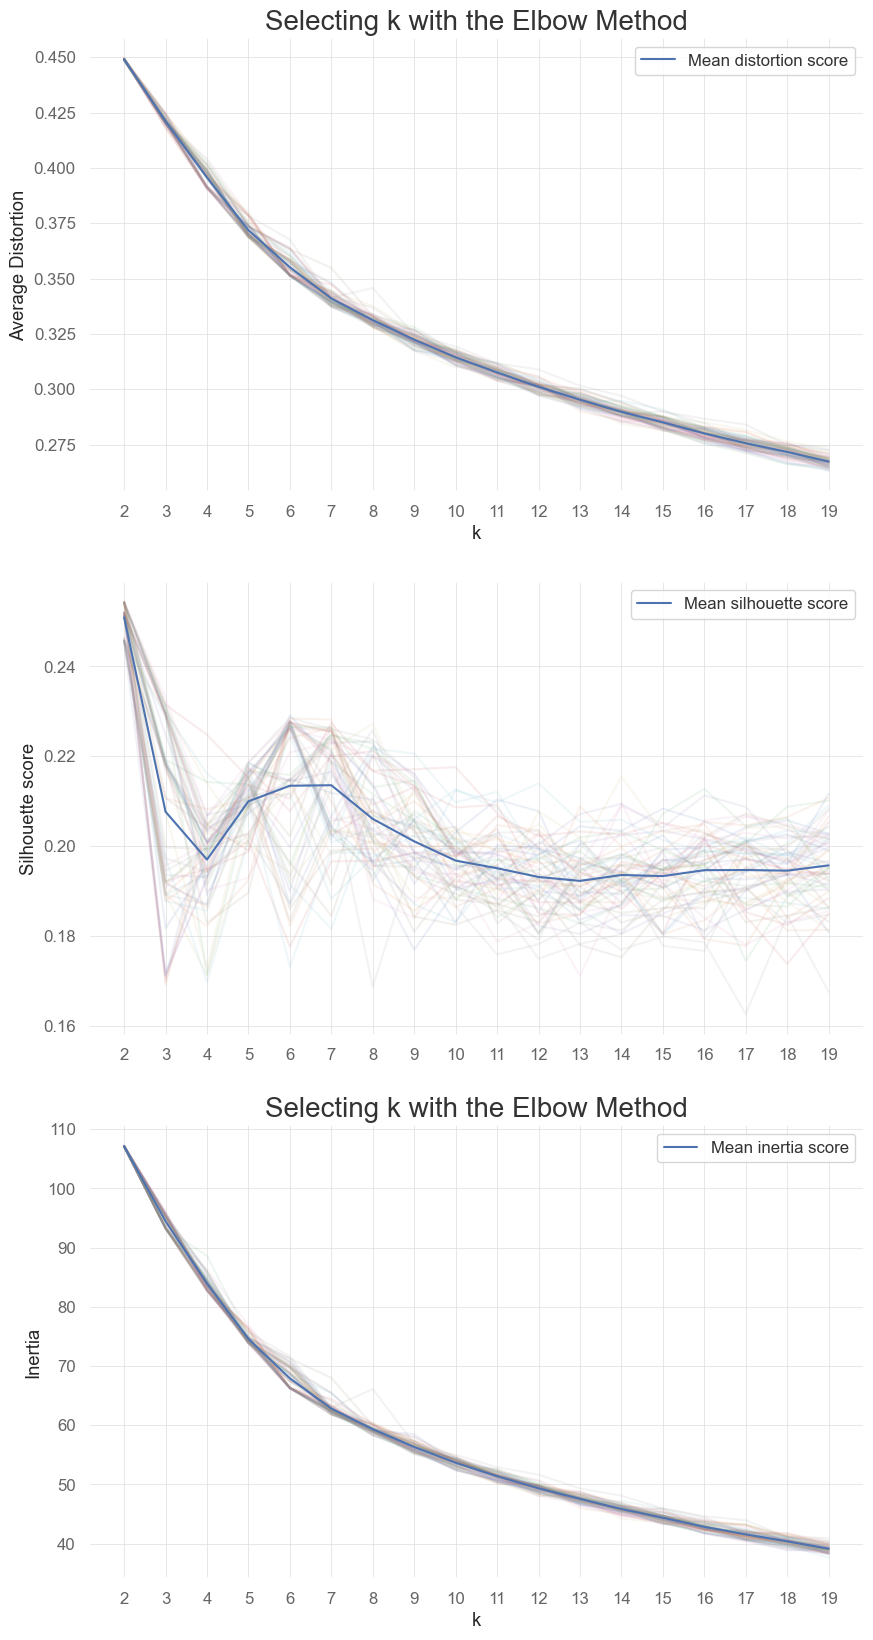

In [16]:
from analysis.data.plotting import plot_kmeans
plot_kmeans(runs, clusters, meanDistortions, sil_score, inertias)

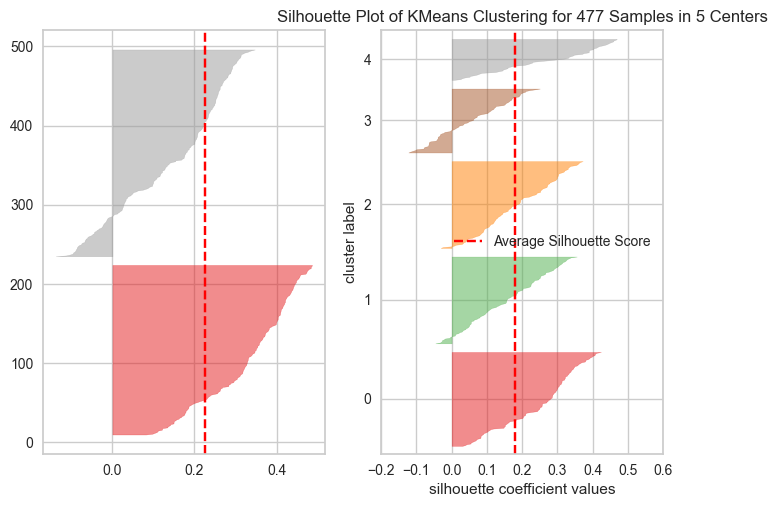

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 477 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
plt.subplot(1,2,1)
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [20]:
N_SECTORS = 5

kmeans = KMeans(n_clusters=N_SECTORS, random_state=0)
kmeans.fit(pca_dataset)
final_dataframe["Sector"] = kmeans.labels_
final_dataframe.head()


,Ticker,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,industry,Sector
0,A,0.170255,0.290318,1.006775,0.707046,2.268208,1.961764e+06,-0.134995,-0.000283,-0.000401,4.334483,0.517552,11.36,1.19,6.23,3.93,Life Sciences Tools and Services,1
1,AAPL,0.309906,0.316770,1.238242,0.796984,2.378506,1.073273e+08,-0.036495,-0.000292,-0.000426,4.924368,0.915194,16.79,0.55,7.52,8.72,Technology,1
2,ABBV,0.159055,0.273195,0.657252,0.490510,2.003774,7.196053e+06,-0.845040,-0.000286,-0.000483,13.941146,0.508994,26.10,1.78,15.70,8.62,Biotechnology,0
3,ABT,0.155088,0.257788,0.853279,0.674864,1.733056,5.701730e+06,0.048210,-0.000290,-0.000434,6.096809,0.524026,22.21,1.81,13.84,6.56,Health Care,0
4,ACGL,0.204344,0.314158,0.979198,0.635494,0.905297,1.859299e+06,-0.321692,-0.000771,-0.001249,11.651915,0.586789,20.27,1.57,9.92,8.78,Insurance,0


In [22]:
cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]


max_cols = ["beta", "mkt_corr", "D_eSkewness", "Yavg_return", "Sharpe_ratio", "Davg_volume"]
min_cols = ["beta", "mkt_corr", "Davg_span", "D_eCurtosis", "Yavg_volatility", "D_eVaR", "D_eCVaR", 
            "totalEsg", "environmentScore", "socialScore", "governanceScore"]

# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == cluster_profile[col_name].max():
        return max_color
    elif col_name in min_cols and val == cluster_profile[col_name].min():
        return min_color
    return ""

cluster_profile.style.apply(lambda x: [highlight_extremes(v, x.name) for v in x], axis=0)

,Yavg_return,Yavg_volatility,beta,mkt_corr,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,Count
Sector,,,,,,,,,,,,,,,,
0,0.141043,0.338408,1.064224,0.642266,2.659950,4844706.024150,-0.047437,-0.000515,-0.000809,12.526874,0.357684,23.130105,2.656737,12.126526,8.347053,95
1,0.178322,0.340296,1.078475,0.647485,4.208005,4700788.301202,-0.068655,-0.000443,-0.000692,10.645098,0.465247,14.716594,3.385072,6.665435,4.665725,138
2,0.160582,0.326159,0.967956,0.607027,3.198147,3477015.519182,-0.143265,-0.000595,-0.000943,10.874831,0.431023,18.248017,5.751736,7.607190,4.888926,121
3,0.107075,0.271572,0.683527,0.512979,1.857741,6128645.927486,-0.113000,-0.000532,-0.000870,14.366961,0.320633,24.608333,9.118333,10.570152,4.920000,66
4,0.212433,0.465354,1.213011,0.542636,2.427407,10082477.916652,-0.054934,-0.001075,-0.001767,14.765528,0.413520,29.734035,13.192281,11.131579,5.410526,57


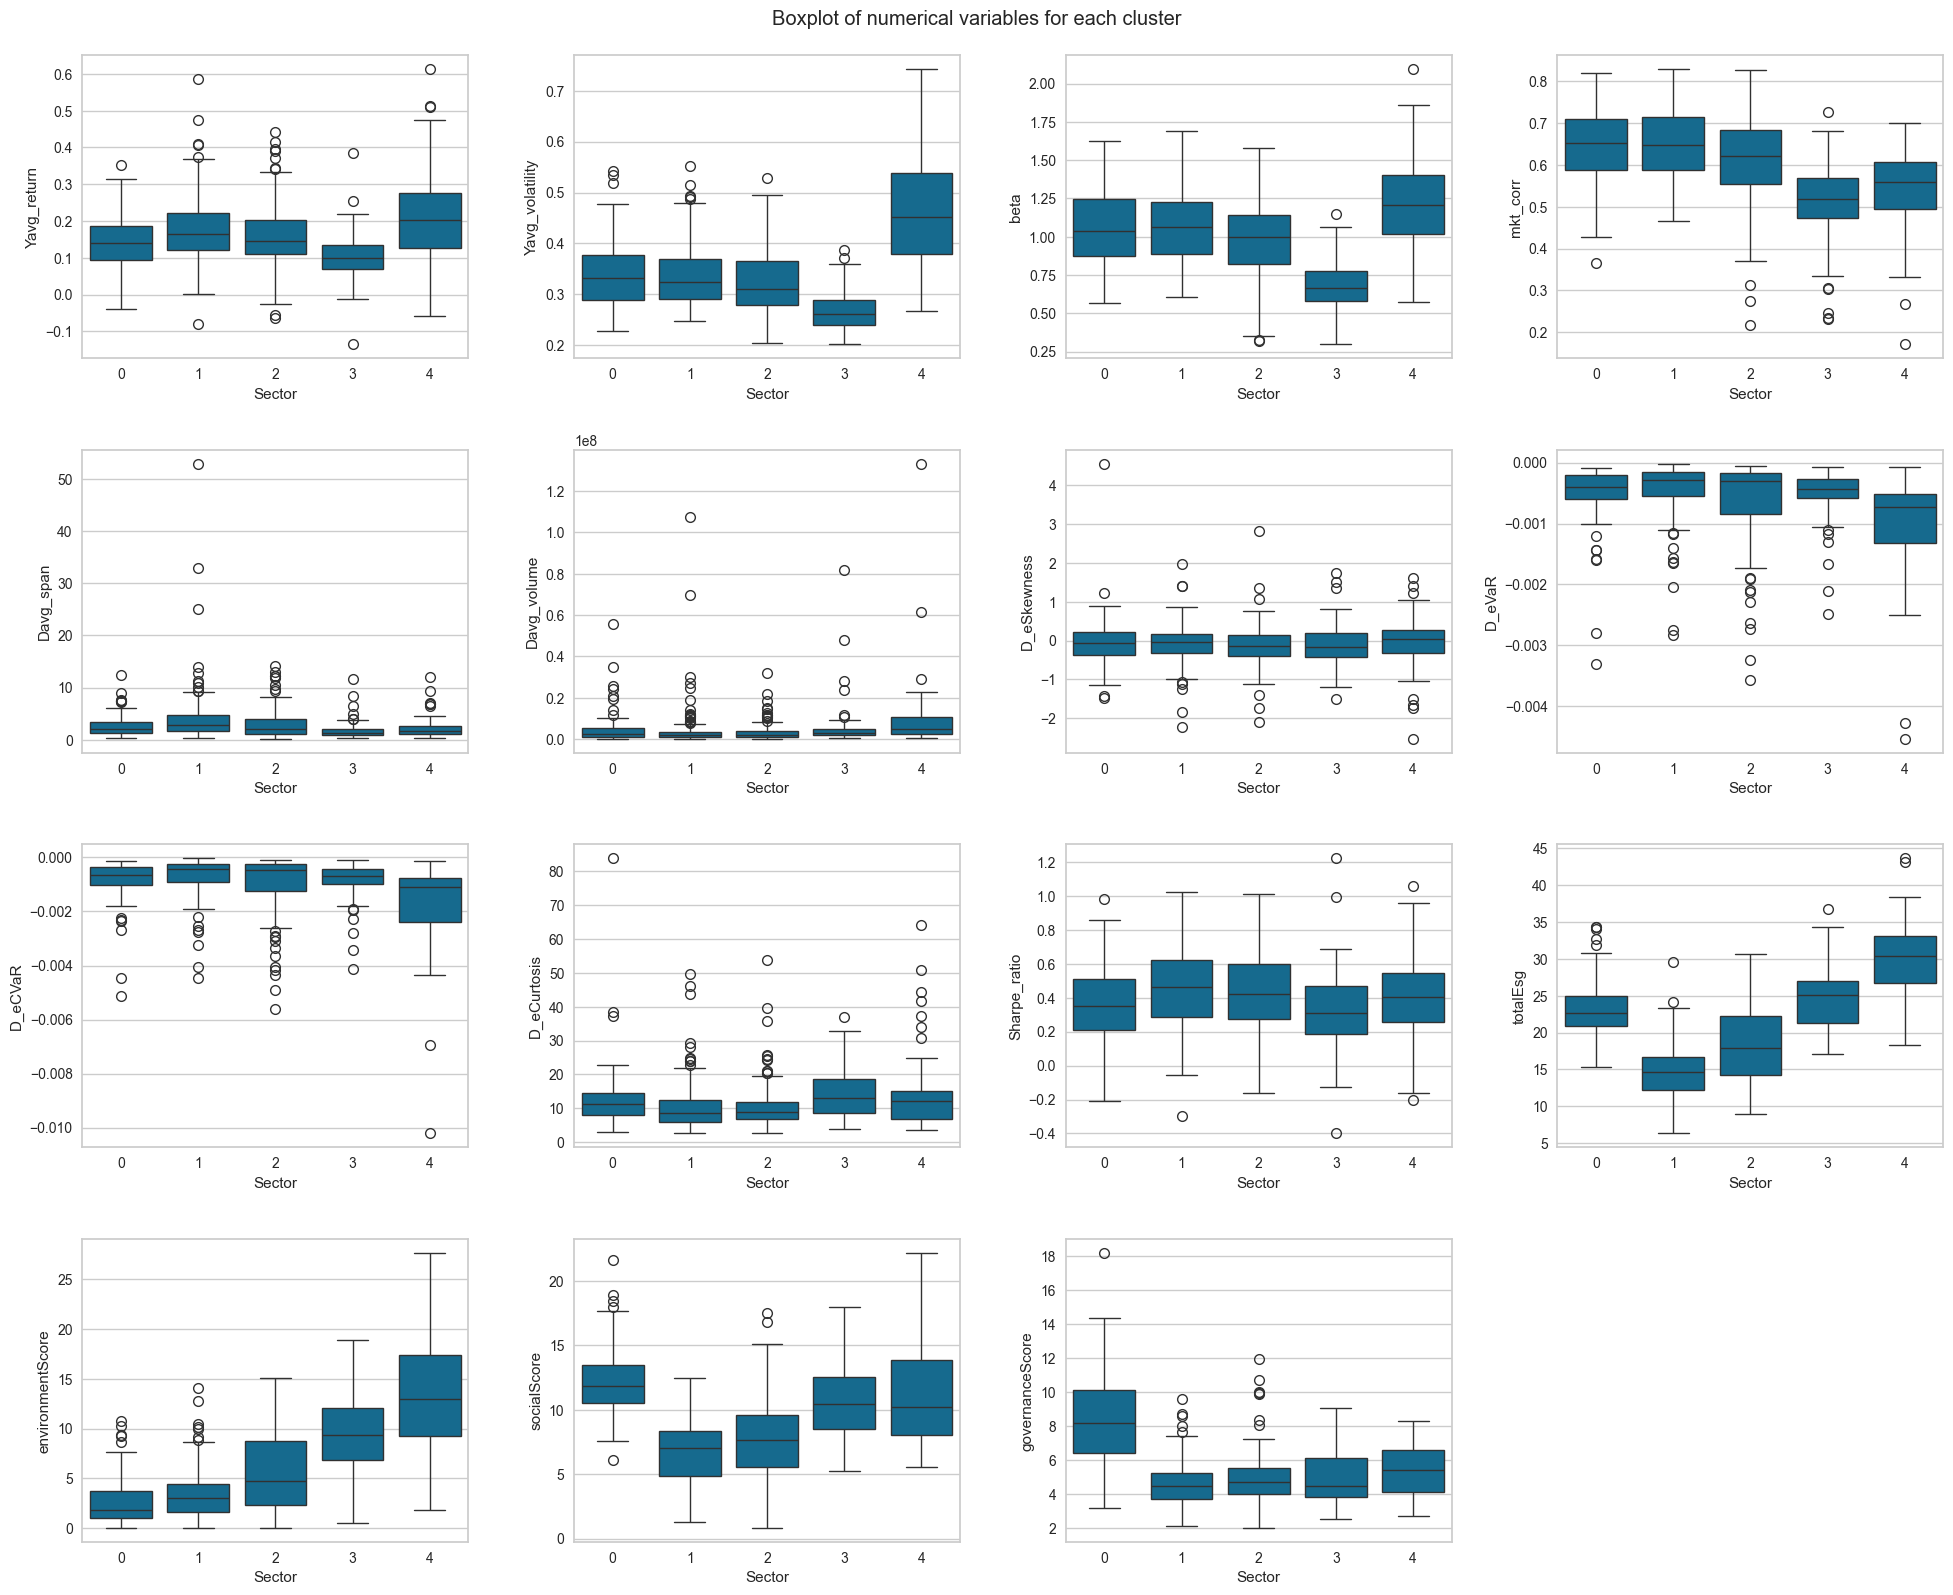

In [23]:
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of numerical variables for each cluster")
i = 1
for i, variable in enumerate(final_dataframe):
  if variable not in ["Ticker", "industry", "Sector"]:
    plt.subplot(5, 4, i)
    sns.boxplot(data=final_dataframe, x="Sector", y=variable)
    i += 1

plt.tight_layout(pad=2.0)

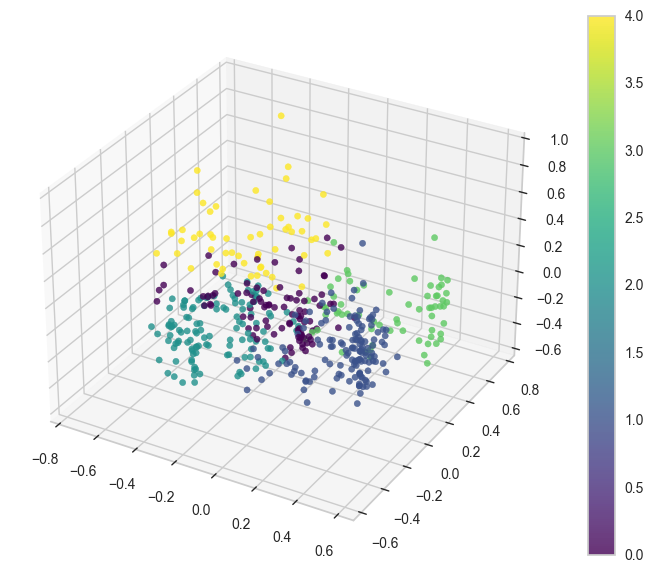

In [24]:
# Assume stock_data_clustering is your features DataFrame
n = 3  # Number of components
projection = PCA(n_components=n).fit_transform(stock_data_clustering)

# Store in DataFrame
projection_df = pd.DataFrame(projection, columns=[f'PC{i+1}' for i in range(n)])

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    projection_df["PC1"], 
    projection_df["PC2"], 
    projection_df["PC3"], 
    c=final_dataframe["Sector"], 
    cmap="viridis", 
    alpha=0.8
)


# Add color bar
plt.colorbar(sc)
plt.show()

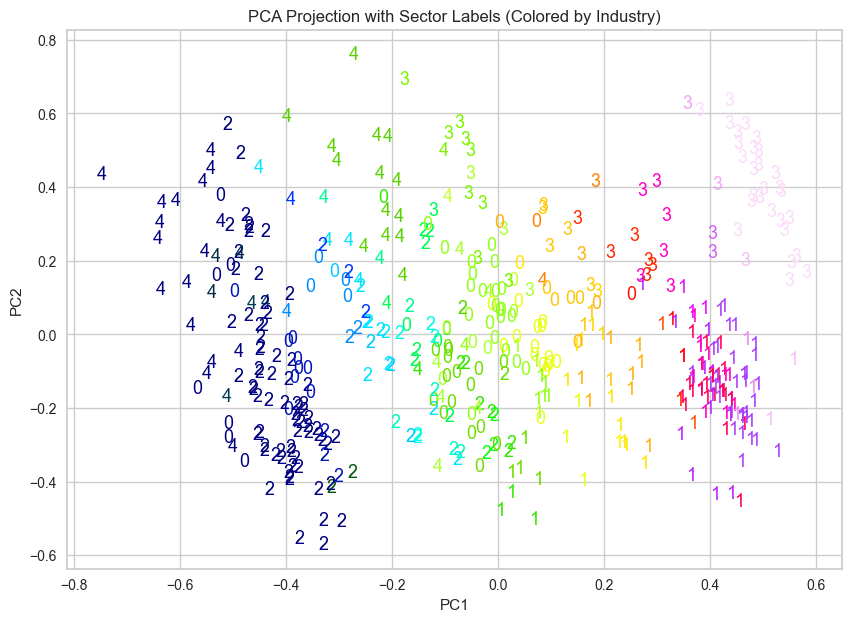

In [26]:
n = 2  # Number of PCA components
projection = PCA(n_components=n).fit_transform(stock_data_clustering)

# Store in DataFrame
projection_df = pd.DataFrame(projection, columns=[f'PC{i+1}' for i in range(n)])

# Get industry-based color mapping
industry_codes = final_dataframe["industry"].astype('category').cat.codes
cmap = plt.get_cmap("tab20")  # Works well for 20 colors
if len(np.unique(industry_codes)) > 20:
    cmap = plt.get_cmap("tab10")  # Use tab10 if more than 20
if len(np.unique(industry_codes)) > 30:
    cmap = plt.get_cmap("gist_ncar")  # More diverse if >30 categories

# Normalize industry codes
industry_codes = final_dataframe["industry"].astype('category').cat.codes
colors = cmap(industry_codes / (industry_codes.max() + 1))

# Create figure
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each point as a number corresponding to final_dataframe["Sector"]
for i in range(len(projection_df)):
    ax.text(
        projection_df.iloc[i]["PC1"],  # X-coordinate
        projection_df.iloc[i]["PC2"],  # Y-coordinate
        str(final_dataframe.iloc[i]["Sector"]),  # Number to display
        fontsize=13, 
        ha="center", 
        va="center",
        color=colors[i],  # Use mapped color
        alpha=1
    )

# Add colorbar for industry reference
sc = ax.scatter(projection_df["PC1"], projection_df["PC2"], c=industry_codes, cmap="viridis", alpha=0)
# cbar = plt.colorbar(sc)
# cbar.set_label("Industry Categories")

# Labels and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA Projection with Sector Labels (Colored by Industry)")

plt.show()

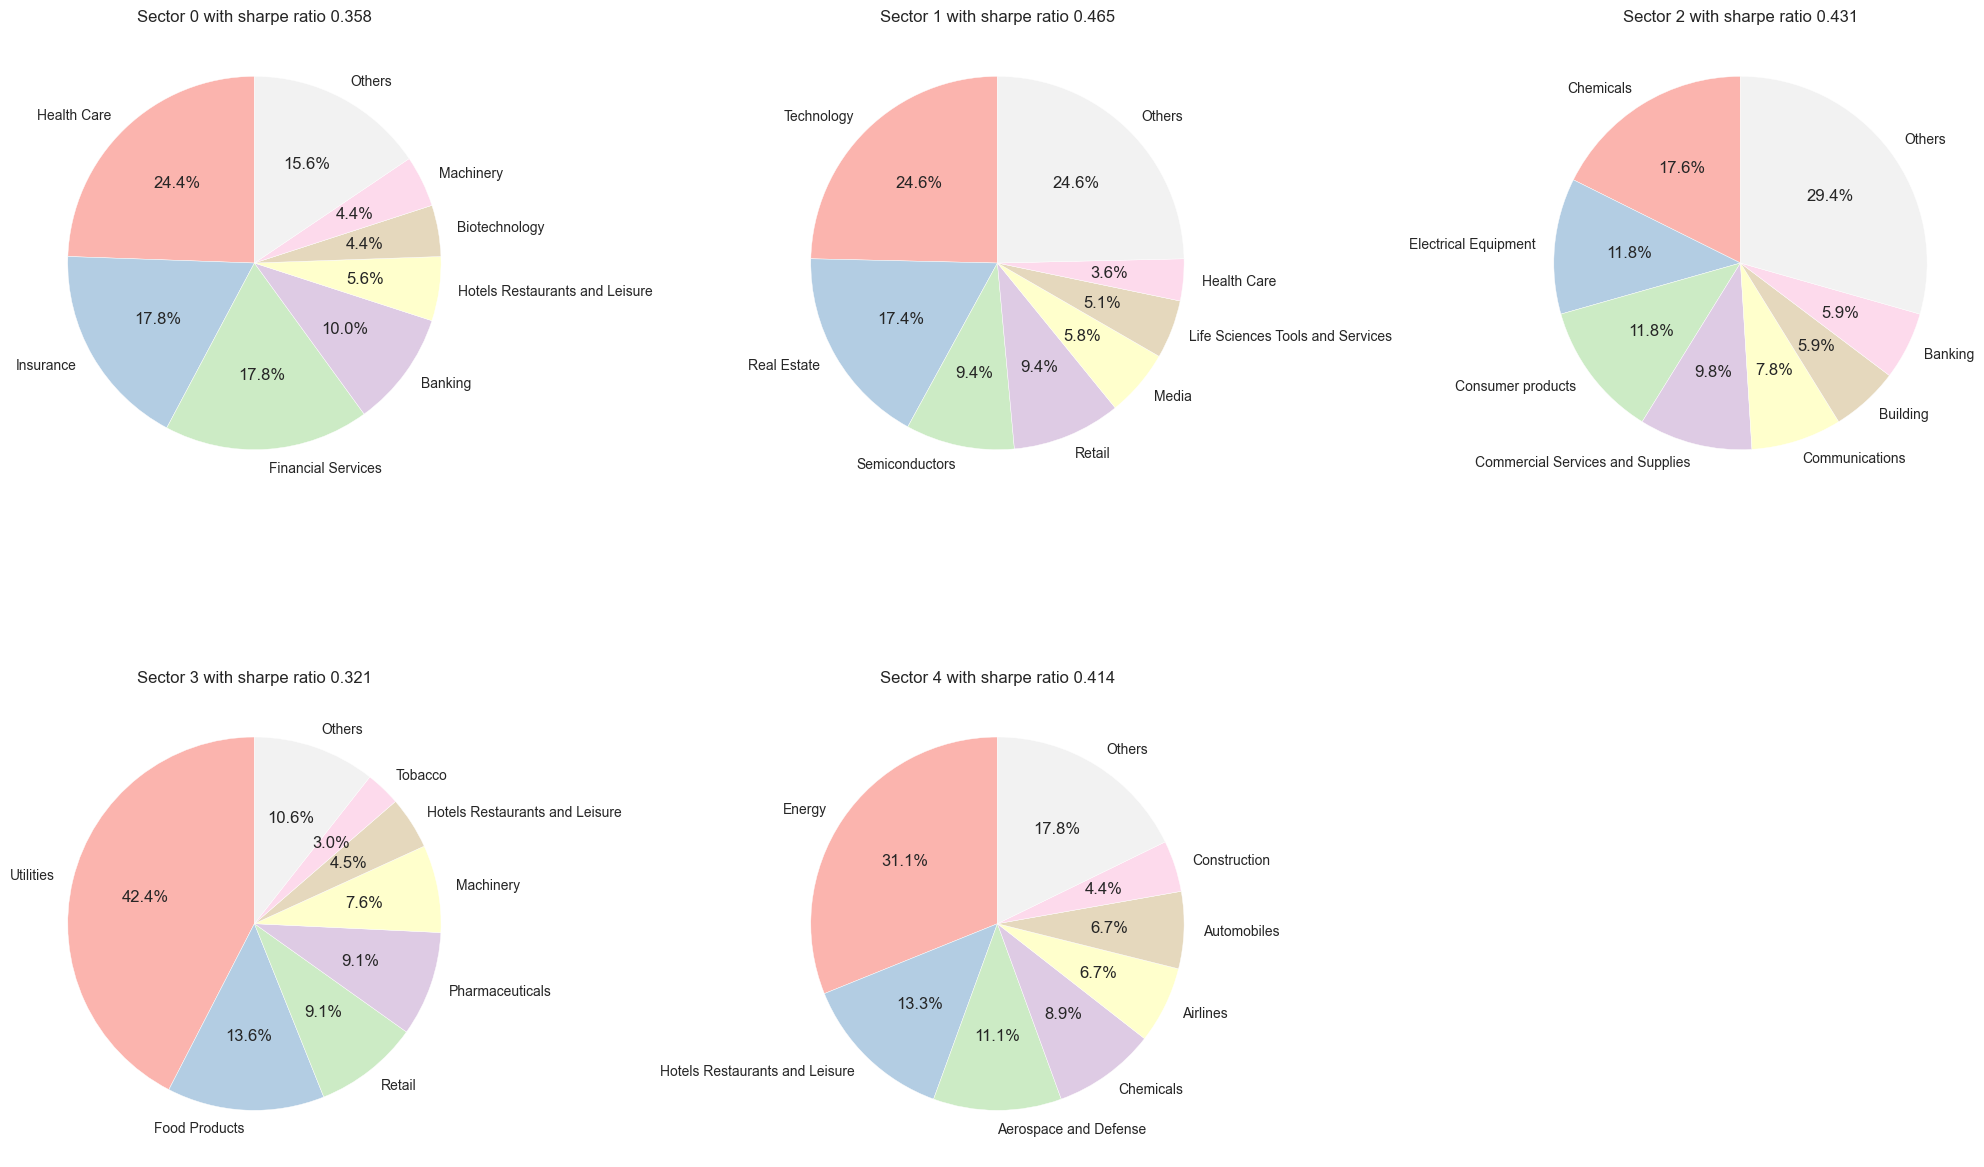

In [27]:
MAX_LABELS = 7
from analysis.data.plotting import plot_cluster_industry
plot_cluster_industry(MAX_LABELS, final_dataframe, cluster_profile)

In [28]:
from analysis.data.dataframe_creation import create_portfolio_clustered
portfolio_ret, asset_ret = create_portfolio_clustered(sd, ed, final_dataframe, list(final_dataframe["Ticker"]), w="uniform")

[*********************100%***********************]  477 of 477 completed


Null values: False
Null values: False


In [29]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


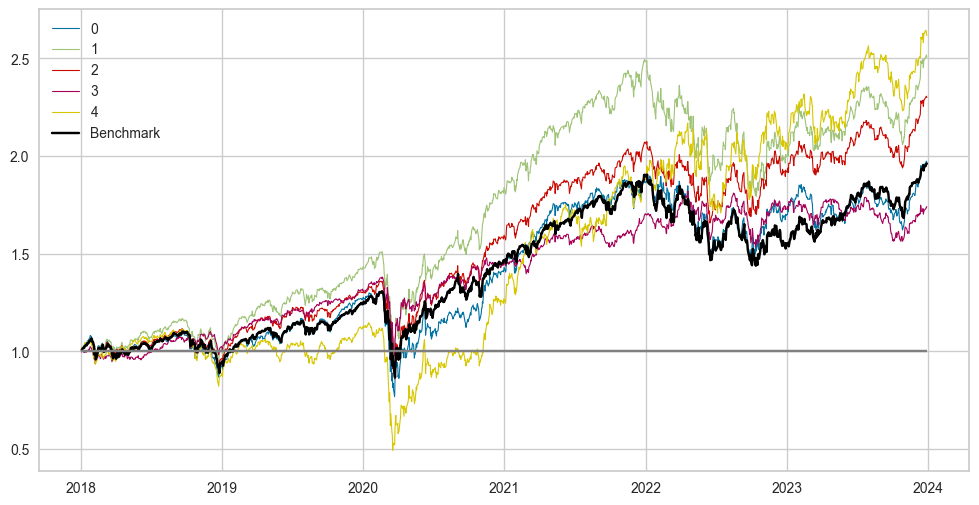

In [30]:
from analysis.data.plotting import portfolio_evolution_time
portfolio_evolution_time(portfolio_ret.reset_index(), benchmark.reset_index())

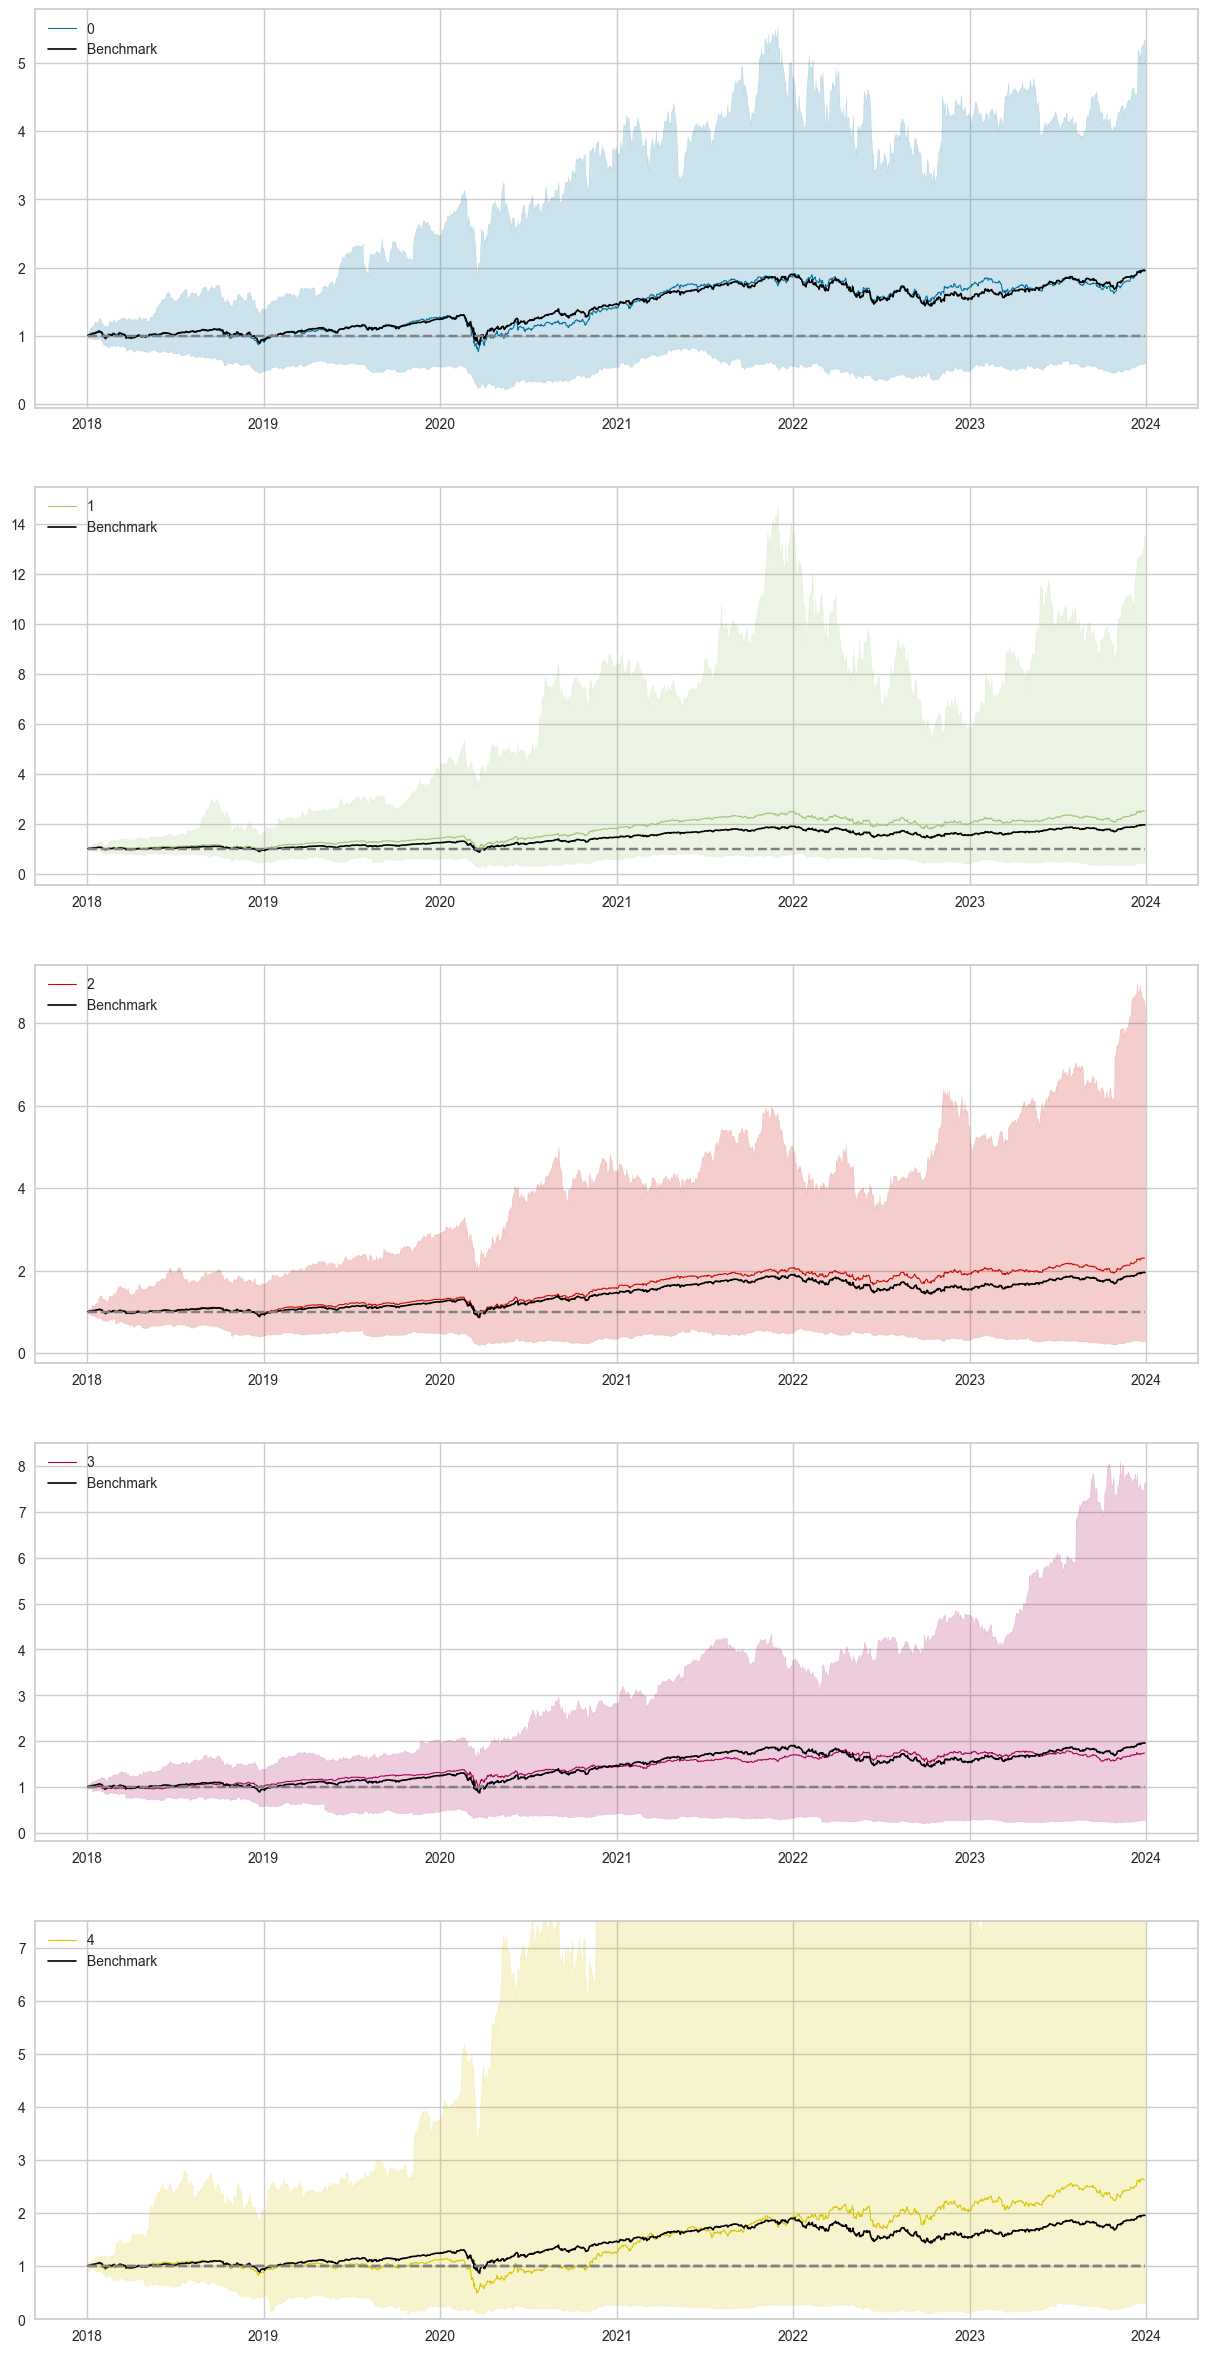

In [31]:
from analysis.data.plotting import portfolio_span
portfolio_span(asset_ret, portfolio_ret, final_dataframe, benchmark, N_SECTORS)

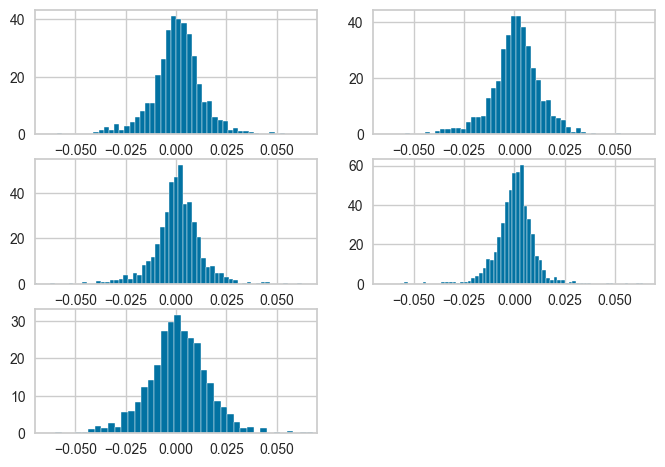

In [32]:
plots = len(portfolio_ret.columns)
for i in range(plots):
    plt.subplot(3,2,i+1)
    plt.hist(portfolio_ret[i], bins=100, density=True)
    plt.xlim(-0.07,0.07)
plt.show()


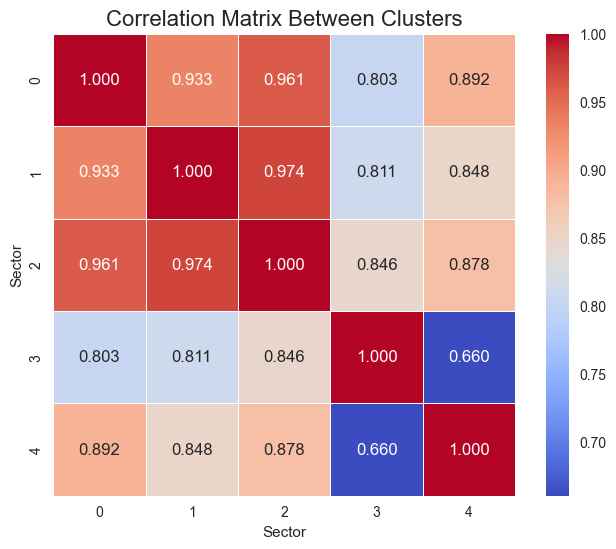

In [33]:
cor_matrix = portfolio_ret.corr()

# 2. Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(
    cor_matrix, 
    annot=True,  # Annotate the heatmap with the covariance values
    fmt=".3f",   # Format for the numbers
    cmap="coolwarm",  # Colormap for the heatmap
    linewidths=0.5,   # Add grid lines
    square=True       # Make the heatmap square
)

# 3. Add a title
plt.title("Correlation Matrix Between Clusters", fontsize=16)
plt.show()

In [39]:
sd_test = ed
ed_test = "2025-01-10"
portfolio_ret_t, asset_ret_t = create_portfolio_clustered(sd_test, ed_test, final_dataframe, list(final_dataframe["Ticker"]), w="uniform")

[*********************100%***********************]  477 of 477 completed


Null values: False
Null values: False


In [40]:
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


In [41]:
def weights(ratios, cluster, pow, thresh):
    w = np.array(ratios["Sharpe_ratio"] > thresh)*ratios["Sharpe_ratio"]
    ratios["weights"] = np.power(w, pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]

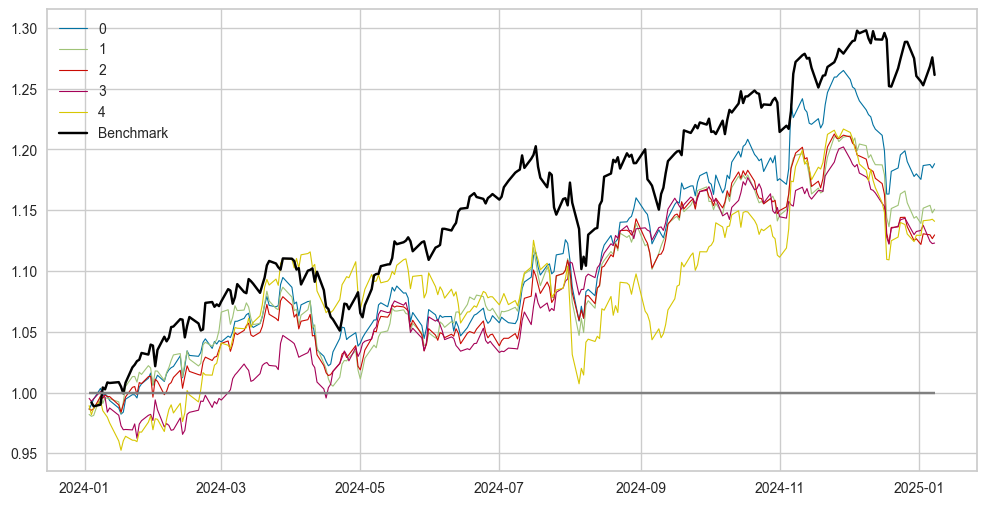

In [42]:
portfolio_evolution_time(portfolio_ret_t.reset_index(), benchmark_t.reset_index())

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-04   2024-01-04
End Period                 2025-01-08   2025-01-08
Risk-Free Rate             2.0%         2.0%
Time in Market             100.0%       100.0%

Cumulative Return          27.36%       19.07%
CAGR﹪                     17.91%       12.62%

Sharpe                     1.81         1.4
Prob. Sharpe Ratio         94.51%       89.35%
Smart Sharpe               1.68         1.31
Sortino                    2.61         2.06
Smart Sortino              2.43         1.91
Sortino/√2                 1.85         1.45
Smart Sortino/√2           1.72         1.35
Omega                      1.26         1.26

Max Drawdown               -8.41%       -7.13%
Longest DD Days            64           50
Volatility (ann.)          12.57%       11.34%
R^2                        0.76         0.76
Information Ratio          -0.07        -0.07
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-12-02,2024-12-19,2025-01-08,38,-7.127396,-6.725517
2,2024-04-01,2024-04-18,2024-05-16,46,-5.600695,-5.523750
3,2024-07-17,2024-08-05,2024-08-16,31,-5.504020,-5.057625
4,2024-09-03,2024-09-06,2024-09-13,11,-3.500444,-2.469148
5,2024-10-21,2024-10-31,2024-11-05,16,-2.970769,-2.861626


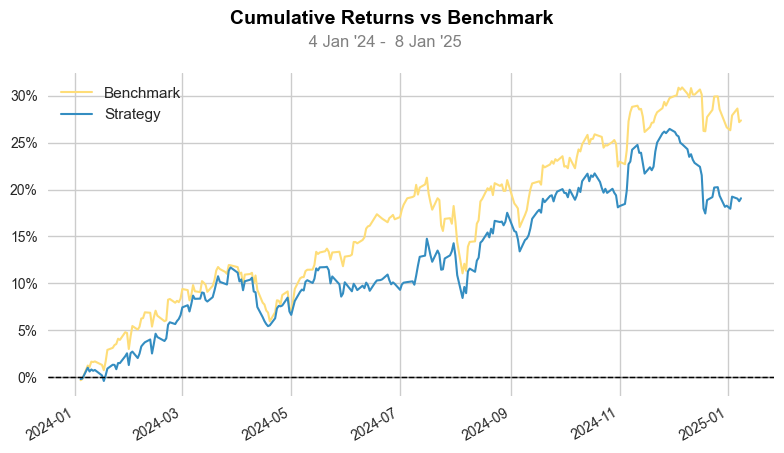

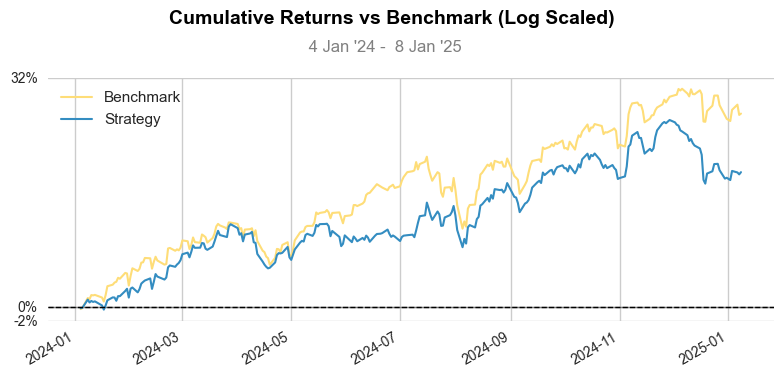

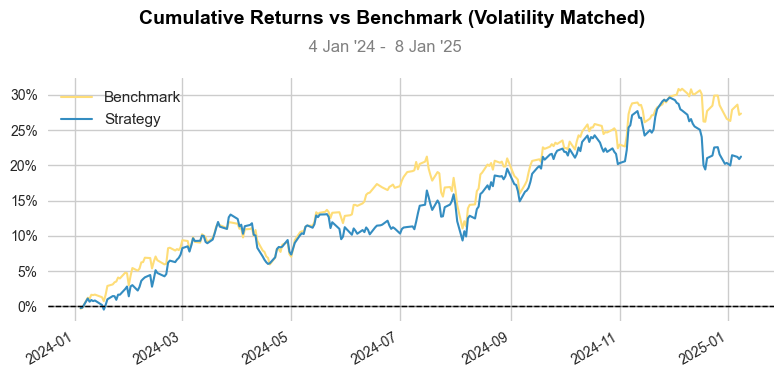

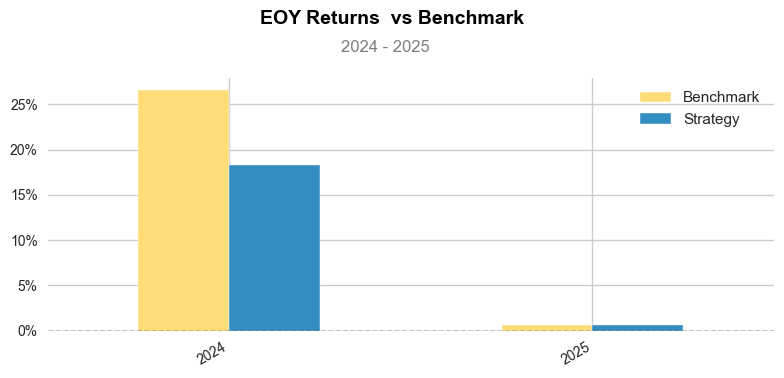

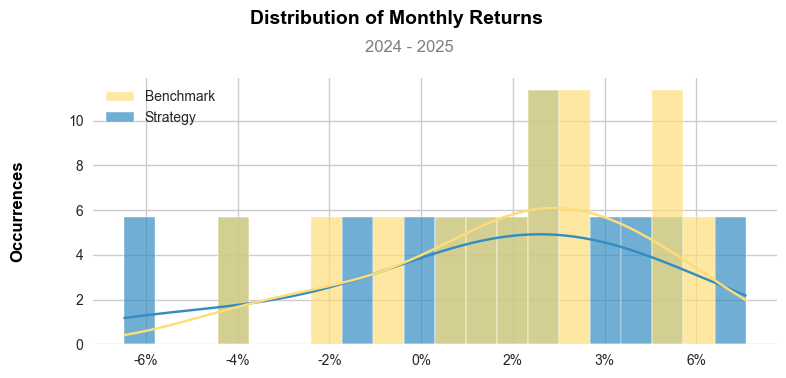

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [60]:
import quantstats as qs

returns = np.zeros(len(portfolio_ret_t))
cp = cluster_profile.reset_index()
for i in portfolio_ret_t.columns:
        weight = weights(cp[["Sector", "Sharpe_ratio"]], i, 1, 0.3).values[0]
        returns += weight*portfolio_ret_t[i] 
portfolio_performance = pd.DataFrame(returns).reset_index()

portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]
# Run the QuantStats full report
qs.reports.full(portfolio_performance["Returns"], benchmark="SPY", rf=0.02)